# Goals:
-	Build a model to predict the number of sales (Item_Outlet_Sales) using the available features.
-	Gain insights about the number of sales.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
%matplotlib inline

# Overview

In [2]:
# read the train data
data = pd.read_csv('Data\BigMart.csv')
# check for the null values
data.isna().sum()
# Drop row number 
data.drop("Unnamed: 0", axis = 1, inplace=True) 


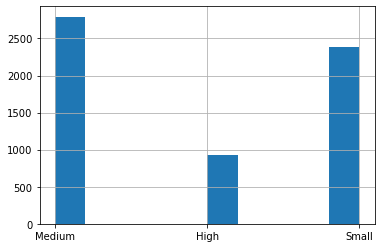

In [3]:
# data.Item_Weight.hist()
data.Outlet_Size.hist()

In [4]:
data.describe()
df_ = data.select_dtypes(exclude=['int', 'float'])
for col in df_.columns:
    print(df_[col].unique()) # to print categories name only
    # print(df_[col].value_counts()) # to print count of every category

['FDA15' 'DRC01' 'FDN15' ... 'NCF55' 'NCW30' 'NCW05']
['Low Fat' 'Regular' 'low fat' 'LF' 'reg']
['Dairy' 'Soft Drinks' 'Meat' 'Fruits and Vegetables' 'Household'
 'Baking Goods' 'Snack Foods' 'Frozen Foods' 'Breakfast'
 'Health and Hygiene' 'Hard Drinks' 'Canned' 'Breads' 'Starchy Foods'
 'Others' 'Seafood']
['OUT049' 'OUT018' 'OUT010' 'OUT013' 'OUT027' 'OUT045' 'OUT017' 'OUT046'
 'OUT035' 'OUT019']
['Medium' nan 'High' 'Small']
['Supermarket Type1' 'Supermarket Type2' 'Grocery Store'
 'Supermarket Type3']


## Data clean

In [5]:
# Fix some irregular values 
data.loc[data['Item_Fat_Content'].isin(['LF','low fat']), 'Item_Fat_Content'] = 'Low Fat'
data.loc[data['Item_Fat_Content'].isin(['reg']), 'Item_Fat_Content'] = 'Regular'

In [6]:
# impute NAs by mean
data.Item_Weight.fillna(data.Item_Weight.mean(),inplace=True)
# during EDA in R, discovered NAs present in Grocery and Supermarket type 1. 
# assume Grocery store are small and use mode for Type1 supermarket 

data.loc[:, ['Outlet_Type', 'Outlet_Size']].drop_duplicates()
data.loc[data['Outlet_Type'].eq('Grocery Store') & data['Outlet_Size'].isna(), 'Outlet_Size'] = 'Small'
data.Outlet_Size.mode()
data.loc[data['Outlet_Type'].eq('Supermarket Type1') & data['Outlet_Size'].isna(), 'Outlet_Size'] = 'Medium'
data.loc[:, ['Outlet_Type', 'Outlet_Size']].drop_duplicates()
data.loc[:, ['Item_Type']].drop_duplicates()
data.Outlet_Location_Type = data.Outlet_Location_Type.astype('str')


In [7]:
# create an object of the OneHotEncoder
Encoder = ce.OneHotEncoder(cols=['Item_Fat_Content',
                                 'Item_Type',
                                'Outlet_Identifier',
                                'Outlet_Size',
                                'Outlet_Location_Type',
                                'Outlet_Type'],use_cat_names=True)
# encode the categorical variables
data = Encoder.fit_transform(data)

In [8]:
# some feature enigeering change supermarket type 2 to 1

# data.loc[data['Item_Type'].isin(['Household', 'Health and Hygiene']), 'Item_Type'] = 'Noneedible'
# data.loc[data['Outlet_Type'].eq('Supermarket Type2'), 'Outlet_Type'] = 'Supermarket Type1'

data.to_csv("Data/cleaned.csv", index=False)

In [9]:
data.isna().sum()
data.describe()

,Item_Weight,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Visibility,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Meat,Item_Type_Fruits and Vegetables,Item_Type_Household,Item_Type_Baking Goods,...,Outlet_Size_Small,Outlet_Size_High,Outlet_Location_Type_1,Outlet_Location_Type_3,Outlet_Location_Type_2,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,...,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.647307,0.352693,0.066132,0.080019,0.052212,0.049865,0.144550,0.106770,0.076030,...,0.345301,0.109351,0.280183,0.393054,0.326763,0.654347,0.108882,0.127068,0.109703,2181.288914
std,4.226124,0.477836,0.477836,0.051598,0.271338,0.222467,0.217679,0.351667,0.308839,0.265061,...,0.475494,0.312098,0.449115,0.488457,0.469057,0.475609,0.311509,0.333069,0.312538,1706.499616
min,4.555000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.290000
25%,9.310000,0.000000,0.000000,0.026989,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,834.247400
50%,12.857645,1.000000,0.000000,0.053931,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1794.331000
75%,16.000000,1.000000,1.000000,0.094585,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3101.296400
max,21.350000,1.000000,1.000000,0.328391,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,13086.964800


In [10]:
# create the StandardScaler
scaler = StandardScaler()
# fit the Item_MRP and Weight
num_cols = ['Item_Weight','Item_Visibility','Item_MRP']

# fit the Item_MRP and Weight
data[num_cols] = scaler.fit_transform(data[num_cols])

In [11]:
# separate the predictors and target variable 
train_X = data.drop(columns=['Item_Identifier','Item_Outlet_Sales'])
train_Y = data['Item_Outlet_Sales']

# randomly split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.2,random_state=0)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((6818, 42), (1705, 42), (6818,), (1705,))

RMSE on train data:  1268501.1273140793
RMSE on test data:  1281083.8530442773
MAE on train data:  831.8945961946745
MAE on test data:  852.5904243931226
r2_score on train data:  0.5637902413362736
r2_score on test data:  0.5623008642251285


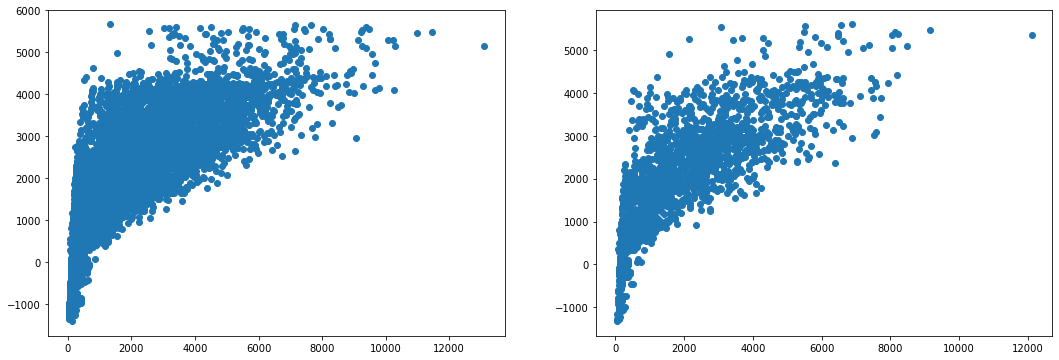

In [12]:
# create an object of the LinearRegression Model
model_LR = LinearRegression(fit_intercept=False)

# fit the model with the training data
model_LR.fit(train_x, train_y)

# predict the target on train and test data 
predict_train = model_LR.predict(train_x)
predict_test  = model_LR.predict(test_x)

print('RMSE on train data: ', mean_squared_error(train_y, predict_train))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test))
print('MAE on train data: ', mean_absolute_error(train_y, predict_train))
print('MAE on test data: ',  mean_absolute_error(test_y, predict_test))
print('r2_score on train data: ', r2_score(train_y, predict_train))
print('r2_score on test data: ',  r2_score(test_y, predict_test))
plt.figure(figsize=(18,6))
plt.subplot(1, 2, 1)
plt.scatter(train_y,predict_train)
# plt.title( 'Link function ' + str(i) + '(Train data)')
plt.subplot(1, 2, 2)
plt.scatter(test_y,predict_test)
# plt.title( 'Link function ' + str(i) + '(Test data)')

In [13]:
d = {'featurename':model_LR.feature_names_in_, 
     'featurecoef':model_LR.coef_}
# coef = pd.Series(model_LR.coef_, model_LR.feature_names_in_, name = 'value').sort_values()

pd.DataFrame(d)


,featurename,featurecoef
0,Item_Weight,-6.887401e+00
1,Item_Fat_Content_Low Fat,1.624083e+12
2,Item_Fat_Content_Regular,1.624083e+12
3,Item_Visibility,-1.895833e+01
4,Item_Type_Dairy,1.820087e+08
5,Item_Type_Soft Drinks,1.820087e+08
6,Item_Type_Meat,1.820087e+08
7,Item_Type_Fruits and Vegetables,1.820088e+08
8,Item_Type_Household,1.820087e+08
9,Item_Type_Baking Goods,1.820088e+08


In [14]:
model_LR.coef_

array([-6.88740080e+00,  1.62408263e+12,  1.62408263e+12, -1.89583312e+01,
        1.82008654e+08,  1.82008697e+08,  1.82008750e+08,  1.82008759e+08,
        1.82008706e+08,  1.82008772e+08,  1.82008744e+08,  1.82008705e+08,
        1.82008770e+08,  1.82008723e+08,  1.82008755e+08,  1.82008788e+08,
        1.82008711e+08,  1.82008840e+08,  1.82008732e+08,  1.82008951e+08,
        9.67978738e+02,  1.91846703e+09,  4.89556944e+09,  3.80125912e+09,
       -3.74585024e+09, -4.91553899e+09, -1.29709389e+09,  2.77063800e+09,
        1.44599923e+09,  1.48462400e+09, -5.27155069e+09, -8.13546340e+08,
        1.82884091e+09,  6.74215906e+08, -3.77269063e+09, -2.89889177e+09,
       -1.39559914e+09,  2.75730800e+09,  1.16607927e+09,  4.82114724e+09,
       -1.87892878e+09, -4.89285477e+09])

In [15]:
# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

print('RMSE on train data: ', mean_squared_error(train_y, predict_train))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test))
print('MAE on train data: ', mean_absolute_error(train_y, predict_train))
print('MAE on test data: ',  mean_absolute_error(test_y, predict_test))
print('r2_score on train data: ', r2_score(train_y, predict_train))
print('r2_score on test data: ',  r2_score(test_y, predict_test))

RMSE on train data:  816826.4400035504
RMSE on test data:  1212920.8803923042
MAE on train data:  634.3424831582118
MAE on test data:  781.0605641186145
r2_score on train data:  0.7191112750380095
r2_score on test data:  0.5855896397027971


# RF is better than LR so far. But overfitting 

# Try a lasso regression to drop some features?

In [16]:
from sklearn import linear_model
regressor = linear_model.Lasso(alpha=100,  
                               positive=True,
                               fit_intercept=False, 
                               max_iter=1000,
                               tol=0.0001)
regressor.fit(train_x, train_y)

Lasso(alpha=100, fit_intercept=False, positive=True)

In [17]:
import eli5
eli5.show_weights(regressor, top=-1, feature_names = train_x.columns.tolist())


Weight?,Feature
+869.526,Item_MRP
+719.257,Outlet_Identifier_OUT027
+231.660,Outlet_Size_Medium
+196.251,Outlet_Type_Supermarket Type1
+0.927,Outlet_Establishment_Year


## Three features lead the way? 
Not sure if it's going to work

In [18]:
train_x

,Item_Weight,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Visibility,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Meat,Item_Type_Fruits and Vegetables,Item_Type_Household,Item_Type_Baking Goods,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Size_High,Outlet_Location_Type_1,Outlet_Location_Type_3,Outlet_Location_Type_2,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3
6404,4.035383e-14,1,0,-1.112703,0,0,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
5820,1.382519e+00,1,0,-0.998345,0,1,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0
48,7.081029e-01,0,1,1.075703,0,0,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0
4583,4.035383e-14,1,0,1.541580,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,1,0
3791,1.926785e+00,1,0,-0.326319,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4373,5.542886e-01,1,0,-0.888686,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
7891,4.035383e-14,0,1,-0.785270,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
4859,1.520051e-01,0,1,-1.281758,0,0,0,0,0,0,...,0,1,0,0,0,1,1,0,0,0
3264,1.382519e+00,1,0,0.751208,0,0,0,0,0,0,...,1,0,0,0,0,1,1,0,0,0


In [23]:
# separate the independent and target variable 
train_X = data.loc[:,['Item_MRP', 'Outlet_Identifier_OUT027', 'Outlet_Type_Supermarket Type1', 'Outlet_Size_Medium']]
train_Y = data['Item_Outlet_Sales']

# split the data
train_x, test_x, train_y, test_y = train_test_split(train_X, train_Y,test_size=0.2,random_state=0)

# shape of train and test splits
train_x.shape, test_x.shape, train_y.shape, test_y.shape

((6818, 4), (1705, 4), (6818,), (1705,))

In [24]:

# create an object of the LinearRegression Model
model_LR = LinearRegression()

# fit the model with the training data
model_LR.fit(train_x, train_y)

# predict the target on train and test data 
predict_train = model_LR.predict(train_x)
predict_test  = model_LR.predict(test_x)

# Root Mean Squared Error on train and test date
print('RMSE on train data: ', mean_squared_error(train_y, predict_train))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test))
print('MAE on train data: ', mean_absolute_error(train_y, predict_train))
print('MAE on test data: ',  mean_absolute_error(test_y, predict_test))
print('r2_score on train data: ', r2_score(train_y, predict_train))
print('r2_score on test data: ',  r2_score(test_y, predict_test))

RMSE on train data:  1388063.7187595672
RMSE on test data:  1410308.112673214
MAE on train data:  883.8692998793588
MAE on test data:  911.874191995009
r2_score on train data:  0.5226752844500488
r2_score on test data:  0.5181496975186519


In [25]:
# create an object of the RandomForestRegressor
model_RFR = RandomForestRegressor(max_depth=10)

# fit the model with the training data
model_RFR.fit(train_x, train_y)

# predict the target on train and test data
predict_train = model_RFR.predict(train_x)
predict_test = model_RFR.predict(test_x)

# Root Mean Squared Error on train and test data
print('RMSE on train data: ', mean_squared_error(train_y, predict_train)**(0.5))
print('RMSE on test data: ',  mean_squared_error(test_y, predict_test)**(0.5))
print('MAE on train data: ', mean_absolute_error(train_y, predict_train))
print('MAE on test data: ',  mean_absolute_error(test_y, predict_test))
print('r2_score on train data: ', r2_score(train_y, predict_train))
print('r2_score on test data: ',  r2_score(test_y, predict_test))

RMSE on train data:  925.8877864427031
RMSE on test data:  1124.0287816810549
MAE on train data:  650.6356973219945
MAE on test data:  789.6698183777177
r2_score on train data:  0.7052042417912885
r2_score on test data:  0.5683288786484851


### Not doing great
Need a pipleline and model selection


In [22]:
# save a cleaned dataset 
data

,Item_Identifier,Item_Weight,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Visibility,Item_Type_Dairy,Item_Type_Soft Drinks,Item_Type_Meat,Item_Type_Fruits and Vegetables,Item_Type_Household,...,Outlet_Size_Small,Outlet_Size_High,Outlet_Location_Type_1,Outlet_Location_Type_3,Outlet_Location_Type_2,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,FDA15,-0.841872,1,0,-0.970732,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,3735.1380
1,DRC01,-1.641706,0,1,-0.908111,0,1,0,0,0,...,0,0,0,1,0,0,1,0,0,443.4228
2,FDN15,1.098554,1,0,-0.956917,0,0,1,0,0,...,0,0,1,0,0,1,0,0,0,2097.2700
3,FDX07,1.500838,0,1,-1.281758,0,0,0,1,0,...,1,0,0,1,0,0,0,1,0,732.3800
4,NCD19,-0.929428,1,0,-1.281758,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,FDF22,-1.418084,1,0,-0.181193,0,0,0,0,0,...,0,1,0,1,0,1,0,0,0,2778.3834
8519,FDS36,-1.059578,0,1,-0.371154,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,549.2850
8520,NCJ29,-0.534243,1,0,-0.599784,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,1193.1136
8521,FDN46,-1.336444,0,1,1.532880,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1845.5976
